# Expectation Maximization

Expectation maximization is very similar to k-means.

Concretely, it fits its training data by repeatedly:
1.  (E-step) Assign each data point (fractionally) to each class.
2.  (M-step) Fit the parameters of each class's model to the data points assigned to it.

The first step is called expectation because it is the expected class assignment, given the class models.
The second step is called maximization because we adjust the parameters of our model to maximize the likelihood of the data, given the assignments.


In addition to the async material, examples of how this is used in practice:
- Topic modelling (partitioning documents into k classes):
  - Assign (fractionally) each document to a topic
  - Fit a bag of words (bernoulli or binomial) model to the documents assigned.

- Gaussian mixture models (teasing apart data points generated by gaussians in various positions):
  - Assign (fractionally) each point to a gaussian
  - Adjust the gaussian's mean and variance to match the points assigned to it.
  
  
We will explore this second case here.

In [24]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Generate data from a mixture of two gaussians

In [90]:
zero_samples = 200
zero_center = -3
zero_std = 1.
one_samples = 800
ones_center = 2
ones_std = 0.5
X = np.hstack([zero_center + zero_std * np.random.randn(zero_samples),
               ones_center + ones_std * np.random.randn(one_samples)])
y = np.hstack([np.zeros(zero_samples), np.ones(one_samples)])

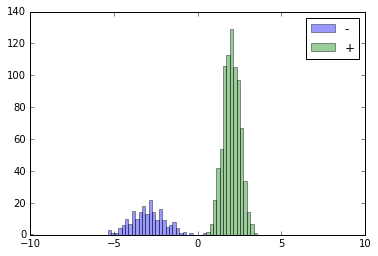

((1000,), (1000,))

In [91]:
def plot_distribution(X, y):
    bins = np.linspace(-10, 10, 100)
    plt.hist(X[y<0.5], bins, alpha=0.4, label='-')
    plt.hist(X[y>=0.5], bins, alpha=0.4, label='+')
    plt.legend(loc='upper_right')
    plt.show()
plot_distribution(X, y)
X.shape, y.shape

## Expectation and Maximization Steps

### Model parameters
The model parameters we are trying to fit are:
- mus[0], sigmas[0]:  the mean of the gaussian generating one of the two classes
- mus[1], sigmas[1]:  the mean of the gaussian generating the other class
- phi: the fraction of data that is in one class vs. the other.

We know the answers to these (we pick them up above).  Here is one of the possible models this code will discover:
- mus[0], sigmas[0]: zero_center, zero_std
- mus[1], sigmas[1]: ones_center, ones_std
- phi: one_samples/(one_samples + zero_samples)

Note that the model has no idea which class was originally "class 1", so it's possible that mu[0] ends up modelling what we called class 1 above and vice versa.  But the set of parameters will be consistent.

### Expectation

This step is similar to k-means where you hold the centroids fixed and assign the data to the nearest point.  The only difference here is that we can hedge our bets a little:  each data point is assigned a little bit to each class.

To compute the expected (fractional) assignment of each $X_i$, we compute its likelihood under each class' model and normalize.  We do this by applying Bayes rule:

$$P(y=j | X, phi, mus, sigmas) = P(x | y=j, mus[j], sigmas[j]) * P(y=j | phi) / Z$$

Note that these mus and sigmas are just numbers estimated by the previous maximization step.

This leaves us the question "What is Z?".  As usual, we solve this by simply adding up the numerators and dividing through by that sum to normalize.

### Maximization
This step is similar to k-means where you move the centroids around, given the data points assigned to them in the E-step.

While in k-means we move centroids around to improve some loss function, here we re-estimate the parameters of the gaussian generators.  Concretely, this means re-estimating mu and sigma for each class' gaussian.

To do this, we assign:
- $phi=\frac{1}{m}\sum w_j$
- $mu_j = \frac{\sum w_j * x_i}{\sum w_j}$
- $sigma_j = \frac{\sum w_j * (x - mu_j)^2}{\sum w_j}$

In [82]:
def gaussian(X, mu, sigma):
    #print X, mu, sigma
    return np.exp(-(X - mu) ** 2) / math.sqrt(2 * math.pi * sigma * sigma)

def expectation(X, phi, mus, sigmas):
    # P(y=j | X, phi, mus, sigmas) = P(x | y=j, mus, sigmas) P(y=j | phi) / Z
    # Where Z is the normalization across all possible j's.
    # w[i][j], at the end of this function, is the assignment (weight) of data point X_i to class j
    w = np.zeros([len(X), len(mus)])
    # For each data point...
    for i in xrange(len(X)):
        # For each class...
        for j in xrange(len(mus)):
            # Determine the (unnormalized) P(y=j | X, ...)
            w[i][j] = gaussian(X[i], mus[j], sigmas[j]) * phi[j]
        # Normalize the distribution P(y=j | X, ...) so that it sums to 1.
        w[i] = w[i] / np.sum(w[i])
    return w

def maximization(X, w):
    # Sum of weight of each class, useful for calculations below.
    w_js = np.sum(w, axis=0)
    # Estimate phi by fraction of weight assigned to each class, overall.
    phi = w_js / np.sum(w)
    # Estimate mus and sigmas by taking the weighted expectations of (X-mu)**2.
    mus = np.dot(w.T, X) / w_js
    x_minus_mu = np.tile(X, [mus.shape[0], 1]).T - mus
    sigmas = np.sum(w * x_minus_mu**2, axis=0) / w_js
    # Return updated estimates.
    return phi, mus, sigmas

In [96]:
def em(X, iterations):
    # Pick priors on mus, sigmas and phi.
    # Should break symmetry here, but otherwise these are arbitrary.
    mus = np.array([0.0, 0.1])
    sigmas = np.array([1.0, 2.0])
    phi = np.array([0.5, 0.5])

    for i in xrange(iterations):
        print 'phi:', phi
        print 'mus:', mus
        print 'sigmas:', np.sqrt(sigmas)
        print '-'
        w = expectation(X, phi, mus, sigmas)
        phi, mus, sigmas = maximization(X, w)

# Experiment!

With that code out of the way, let's see how well we can recover the distributions generating our data.

You can see it converges (very) quickly.

In [98]:
em(X, 5)

phi: [ 0.5  0.5]
mus: [ 0.   0.1]
sigmas: [ 1.          1.41421356]
-
phi: [ 0.61653859  0.38346141]
mus: [ 0.71550178  1.48451346]
sigmas: [ 2.26667182  1.63776527]
-
phi: [ 0.3569243  0.6430757]
mus: [-0.89052157  2.06544406]
sigmas: [ 2.46177969  0.51014505]
-
phi: [ 0.19914183  0.80085817]
mus: [-2.97485282  2.00136027]
sigmas: [ 0.96222455  0.50268568]
-
phi: [ 0.19745206  0.80254794]
mus: [-2.99662707  1.99623998]
sigmas: [ 0.93550214  0.51503928]
-
